In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install librosa

#### **Understanding the data:**

In [0]:
import librosa
from librosa import display
data, sampling_rate = librosa.load('/content/drive/My Drive/Emotion Detection/Audio_Files_Actors_01_24/Actor_02/03-02-01-01-01-01-02.wav')

Populating the interactive namespace from numpy and matplotlib


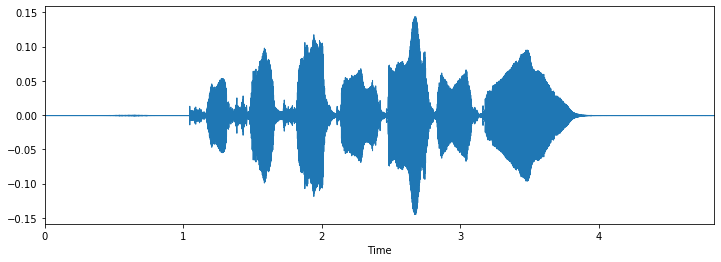

In [8]:
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

#### **1. Data Preprocessing:**

In [0]:
# import time

# path = '/content/drive/My Drive/Emotion Detection/Audio_Files_Actors_01_24/'
# lst = []

# start_time = time.time()

# for subdir, dirs, files in os.walk(path):
#   for file in files:
#       try:
#         #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
#         X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
#         mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
#         # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
#         # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
#         file = int(file[7:8]) - 1 
#         arr = mfccs, file
#         lst.append(arr)
#       # If the file is not valid, skip it
#       except ValueError:
#         continue

# print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 769.2145068645477 seconds ---


In [0]:
# # Creating data and labels .npy file as extracted from the list for future use
# X, y = zip(*lst)
# X = np.asarray(X)
# y = np.asarray(y)
# np.save('/content/drive/My Drive/Emotion Detection/X.npy',X)
# np.save('/content/drive/My Drive/Emotion Detection/labels.npy',X)

In [0]:
# Loading available joblib files for X and y without needing to preprocess the data again
import joblib
X = joblib.load('/content/drive/My Drive/Emotion Detection/X.joblib')
y = joblib.load('/content/drive/My Drive/Emotion Detection/y.joblib')

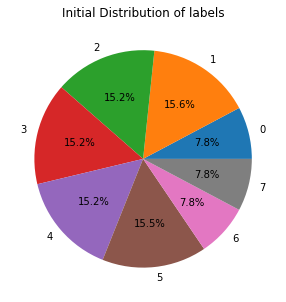

In [10]:
plt.figure(figsize=(8,5))
labels = list(set(y))
counts = []
for label in labels:
    counts.append(np.count_nonzero(y == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Initial Distribution of labels")
plt.show()

The dataset is imbalanced w.r.t to the labels available. SMOTE is used in here to balance it.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


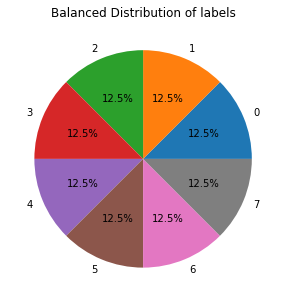

In [11]:
## Balancing the class labels
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=42, k_neighbors=1)
X, y = smt.fit_sample(X, y)

plt.figure(figsize=(8,5))
labels = list(set(y))
counts = []
for label in labels:
    counts.append(np.count_nonzero(y == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Balanced Distribution of labels")
plt.show()

#### **2. Using XGBoost classifier:**

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
# Converting the dataframe into XGBoost’s Dmatrix object
dtrain = DMatrix(X_train, label=y_train)

In [0]:
params = {'max_depth': 7,
          'gamma': 0.01,
          'n_estimators': 200,
          'learning_rate':0.01,
          'subsample': 0.8,
          'eta': 0.1,
          'eval_metric': 'rmse'}

classifier = XGBClassifier(**params).fit(X_train, y_train)


In [16]:
# predicting for test set
y_preds = classifier.predict(X_test)
print(classification_report(y_preds, y_test))
# Attained prediction accuracy on the training set
cm = confusion_matrix(y_preds, y_test)
acc = cm.diagonal().sum()/cm.sum()
print("By the confusion matrix, the accuracy of the XGB model is =",acc)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       161
           1       0.94      0.93      0.93       148
           2       0.79      0.96      0.87       125
           3       0.77      0.93      0.84       153
           4       0.92      0.97      0.94       146
           5       0.80      0.91      0.85       125
           6       1.00      0.75      0.86       194
           7       0.97      0.82      0.89       182

    accuracy                           0.89      1234
   macro avg       0.90      0.90      0.89      1234
weighted avg       0.91      0.89      0.89      1234

By the confusion matrix, the accuracy of the XGB model is = 0.8922204213938412


#### **3. Using CNN:**



---

With a XGBoost algorithm, we were able to achieve a performance of > 86 % on the test set. We want to see if we can achieve a better performance with the convolutional networks. In time, we will try to train an ensemble of CNNs to increase the efficiency by decreasing the epochs for training.

---



In [19]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
# Partition into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
# Partition into train and validation
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [0]:
X_train_cnn = np.expand_dims(X_train, axis=2)
X_eval_cnn = np.expand_dims(X_eval, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)
X_train_cnn.shape, X_eval_cnn.shape, X_test_cnn.shape

((4440, 40, 1), (1111, 40, 1), (617, 40, 1))

In [0]:
def train_model(X_train,X_eval, y_train, y_eval,batch_size,initializer,lr = 1e-3,epochs=10):
  model = Sequential()
  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(40,1),kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Flatten())
  model.add(Dense(8,kernel_initializer=intializer))
  model.add(Activation('softmax'))
  print("------------------MODEL SUMMARY------------------")
  model.summary()
  print("------------------MODEL TRAINING------------------")
  opt = keras.optimizers.rmsprop(lr=lr,rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_eval,y_eval),verbose=True)

  return model,model_history

In [18]:
intializer = keras.initializers.glorot_normal(seed=None)
model, model_history = train_model(X_train_cnn, X_eval_cnn,y_train,y_eval,8,intializer,lr = 0.00005,epochs=100)

NameError: ignored



---


The following plot(s) will assess the accuracy and loss for training and validation sets for more pictorial analysis of the learning phase. Following it would be a detailed analysis of the model's performance using 'classification_report' and 'confusion_matrix' which will allow us to observe other aspects of the model's effectivity.




---



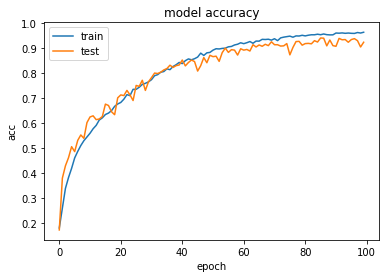

In [0]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

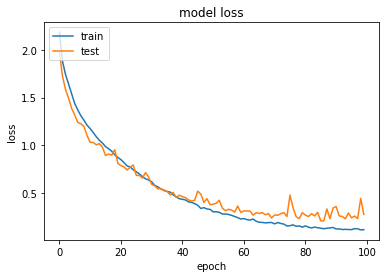

In [0]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
predictions = model.predict_classes(X_test_cnn)

In [0]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        76
           1       0.82      0.93      0.87        67
           2       0.92      0.82      0.87        73
           3       0.92      0.88      0.90        93
           4       0.98      0.97      0.97        91
           5       0.89      0.83      0.86        66
           6       0.93      1.00      0.96        67
           7       0.97      1.00      0.98        84

    accuracy                           0.92       617
   macro avg       0.92      0.92      0.92       617
weighted avg       0.92      0.92      0.92       617



In [0]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[72  4  0  0  0  0  0  0]
 [ 2 62  3  0  0  0  0  0]
 [ 2  5 60  2  0  3  0  1]
 [ 0  3  2 82  0  4  1  1]
 [ 0  1  0  0 88  0  1  1]
 [ 0  1  0  5  2 55  3  0]
 [ 0  0  0  0  0  0 67  0]
 [ 0  0  0  0  0  0  0 84]]


In [0]:
model_name = 'Emotion_Voice_Detection_Single_Model.h5'
save_dir = '/content/drive/My Drive/Emotion Detection/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Emotion Detection/Emotion_Voice_Detection_Single_Model_2_epoch_100.h5 


#### **4. Using a simple CNN Ensemble:**



---


With this we use the same model re-initialized in each iterations and then use the collected list of models (each with it's own performance characterstics) to predict the labels followed by ensemble voting. Found considerable improvement, accuracy shoots to > 90%.


---



In [0]:
def train_model_ensemble(X_train,X_eval, y_train, y_eval,batch_size, intializer,lr = 1e-3,epochs=10):
  model = Sequential()
  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(40,1),kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Conv1D(128, 5,padding='same',kernel_initializer=intializer))
  model.add(Flatten())
  model.add(Dense(8,kernel_initializer=intializer))
  model.add(Activation('softmax'))
  print("------------------MODEL TRAINING------------------")
  model.summary()
  opt = keras.optimizers.rmsprop(lr=lr,rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_eval,y_eval),verbose=False)

  return model,model_history

In [0]:
# We're training the network 5 times but each time with a new intialization causing a new model to be trained at each turn.
models = []
history = []
times = 6
for i in range(times):
  print("------------------MODEL [",i+1,"]------------------")
  intializer = keras.initializers.glorot_normal(seed=None)
  model, model_history = train_model_ensemble(X_train_cnn, X_eval_cnn,y_train,y_eval,8,intializer,lr = 0.00005,epochs=100)
  models.append(model)
  # history.append(model_history)
  model_name = 'Emotion_Voice_Detection_Model'+str(i+1)+'.h5'
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)

------------------MODEL [ 1 ]------------------
------------------MODEL TRAINING------------------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_19 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 40, 128)           82048     
_________________________________________________________________
activation_20 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_____________________

In [0]:
# Predict labels with models
import scipy
predictions = []
for m in models:
    predicts = np.argmax(m.predict(X_test_cnn),axis=1)
    predictions.append(predicts)
    
# Ensemble with voting
predictions = np.array(predictions)
predictions = np.transpose(predictions, (1, 0))
predictions = scipy.stats.mode(predictions, axis=1)[0]
predictions = np.squeeze(predictions)

In [0]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        76
           1       0.91      0.96      0.93        67
           2       0.94      0.88      0.91        73
           3       0.92      0.91      0.92        93
           4       1.00      0.99      0.99        91
           5       0.90      0.91      0.90        66
           6       0.99      1.00      0.99        67
           7       0.99      1.00      0.99        84

    accuracy                           0.95       617
   macro avg       0.95      0.95      0.95       617
weighted avg       0.95      0.95      0.95       617



In [0]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[75  1  0  0  0  0  0  0]
 [ 2 64  1  0  0  0  0  0]
 [ 0  2 64  2  0  5  0  0]
 [ 0  2  2 85  0  2  1  1]
 [ 0  1  0  0 90  0  0  0]
 [ 0  0  1  5  0 60  0  0]
 [ 0  0  0  0  0  0 67  0]
 [ 0  0  0  0  0  0  0 84]]
